# Detección de Anomalias

Con anterioridad hemos enfocado nuestros esfuerzos en encontrar patrones similares dentro de nuestros datos, y los hemos generalizado con ayuda de modelos supervisados o no supervisados. Por ejemplo, hemos encontrado perfiles similares gracias a regresiones logísticas, o hemos sido capaces de conglomerar registros a través de modelos de k-means. Incluso hemos podido agrupar no solo registros (filas), sino atributos (columnas) con técnicas como PCA.

Sin embargo a veces necesitamos exactamente lo opuesto: Por ejemplo si nos encontramos en un banco, tenemos el registro de transacciones bancarias, y lo que queremos es detectar fraudes, estos claramente tienen un comportamiento poco usual respecto a la mayoría de las transacciones. Para esta clase de situaciones, necesitamos algoritmos que nos permitan detectar registros que tengan un comportamiento atípico al resto. Es decir, necesitamos detectar anomalias.

Por defecto, esta es una clase de modelo no supervisado, pues en general no sabemos que registro es anómalo en un set de datos. Por motivos expositivos, hoy trabajaremos con sets de datos donde sí sabremos si un registro es anómalo o no solo para comparar la calidad de los modelos, pero hay que tener en cuenta que la calidad de nuestra predicción no puede ser comprobada con métricas, y la manera usual de saber la verosimilitud de nuestros resultados, es analizando los registros detectados como anómalos a mano.

En esta clase veremos dos formas diferentes de hacer dicha detección:

- A través de análisis de componentes principales: En esta ocasión lo estudiaremos a nivel de registro, y no a nivel de atributo como en la clase pasada.
- A través del algoritmo Isolation Forest: Al igual que Random Forest, es un algoritmo que se encarga de promediar los resultados de múltiples árboles, que en este caso son llamados Isolation Trees, donde cada uno es encargado de detectar una patrón anómalo.


Sin embargo, existe un amplio espectro de algoritmos de detección de anomalías como:

- Local Outlier Factor (LOF).
- One-Class SVM.
- Elliptic Envelope
- Etc.


También hay modelos lineales de regresión que son insensibles a anomalías (también llamados robustos), por ejemplo:
- Huber.
- RANSAC.
- Theil Sen.

Estos tres algoritmos se encuentran disponibles en el módulo `linear_model` de `sklearn`.

Para algoritmos de detección de anomalías más complejos, está disponible la librería `pyod`: <https://pyod.readthedocs.io/en/latest/>.

En el siguiente link podremos encontrar diferentes sets de datos en donde los registros anómalos tienen una marca: <http://odds.cs.stonybrook.edu/#table1>



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn")
%config InlineBackend.figure_format = "svg"

## Análisis de componentes principales

Recordemos que PCA nos permite simplificar la complejidad de espacios muestrales con múltiples dimensiones y a la vez conserva su información. Vimos que cada PCA se forma a través de una combinación de los atributos originales (combinación lineal), y pudimos evaluar la calidad de dichas componentes explorando la cantidad de varianza explicada. 

Lo interesante es que con las proyecciones que pudimos obtener, y los componentes principales, pudimos reconstruir nuestros registros iniciales con la siguiente formula:

$$\text{reconstrucción}=\text{proyecciones}\cdot\text{componentes}^\top $$

Lo cual nos permitía obtener todos nuestros registros, utilizando todas nuestras componentes, y finalmente solo utilizabamos la cantidad de componentes que explicaban la varianza que nos satisfacía.

Como utilizabamos todas nuestras componentes para la reconstrucción, no existía error y obteníamos todos nuestros registros. Realizemos rápidamente el proceso de PCA para los datos glass, utilizaremos además, la función `inverse_transform` del objeto PCA. El proceso lo haremos con un pipeline, pues recordemos que PCA requiere de variables numéricas estandarizadas:

In [2]:
# !pip install fastparquet
data = pd.read_parquet("https://raw.githubusercontent.com/DiegoHoliwis/Diplomado_DS/main/Bases_Python/creditcard.parquet")

print("Dimensiones:", data.shape)
print("Primeras observaciones:")
display(data.head())

Dimensiones: (284807, 30)
Primeras observaciones:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# eliminamos la etiqueta 
X = data.drop(columns="Class")
y = data["Class"]

print("Primeras observaciones:")
display(X.head())
print("Fraude:")
print(y.value_counts())


Primeras observaciones:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


Fraude:
0    284315
1       492
Name: Class, dtype: int64


In [4]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995
V10,284807.0,2.239053e-15,1.088850,-24.588262,-0.535426,-0.092917,0.453923,23.745136


Para encontrar anomalías con el algoritmo PCA, en adelante usaremos la data estandarizada:

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

estand = StandardScaler()
X_est = pd.DataFrame(
    data    = estand.fit_transform(X),
    columns = X.columns
)
print("Data estandarizada:")
display(X_est.head())

Data estandarizada:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


In [6]:
pca = PCA(random_state=2022)
pca.fit(X_est)

PCA(random_state=2022)

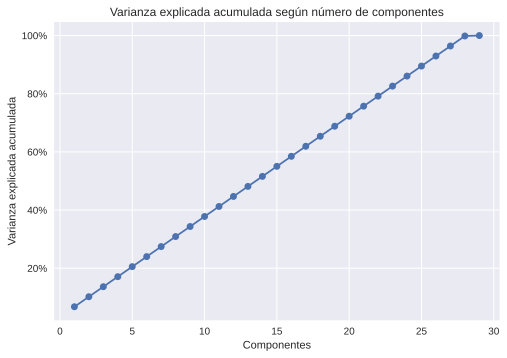

In [7]:
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(lambda x, pos: f"{x:0.0%}")

varianza_explicada = np.cumsum(pca.explained_variance_ratio_)

fig, ax = plt.subplots()
ax.plot(
    range(1, varianza_explicada.shape[0] + 1),
    varianza_explicada,
    marker="o"
)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel("Componentes")
ax.set_ylabel("Varianza explicada acumulada")
ax.set_title("Varianza explicada acumulada según número de componentes");

In [8]:
proyecciones = pca.transform(X_est)
reconstruccion = pca.inverse_transform(proyecciones)

reconstruccion = pd.DataFrame(
    data    = reconstruccion,
    columns = X_est.columns,
    index   = X_est.index
)

print('Valores reconstruidos:')
display(reconstruccion.head())

print('Valores originales:')
display(X_est.head())

Valores reconstruidos:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


Valores originales:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


Lo importante es que al reconstruir los datos con todas las PCA no hubo error. Ahora, si utilizamos menos componentes para la reconstrucción, si cometeriamos un error: el error cuadrático medio de reconstrucción de una observación. Se calcula como el promedio de las diferencias al cuadrado entre el valor original de sus variables y el valor reconstruido, es decir, el promedio de los errores de reconstrucción de todas sus variables elevados al cuadrado.

Como el objetivo es identificar outliers, hay que emplear únicamente un subconjunto de las componentes. En el último gráfico, podemos observar que con 23 componentes, tenemos aprox. un 81% de variabilidad explicada.

Repitamos este procedimiento pero solo con 23 componentes:

In [9]:
pca23 = PCA(n_components=23, random_state=2022)
pca23.fit(X_est)

PCA(n_components=23, random_state=2022)

In [10]:
# Proyectar los datos
proyecciones = pca23.transform(X_est)
print("Primeras filas de las proyecciones:")
display(pd.DataFrame(proyecciones).head())

Primeras filas de las proyecciones:


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.323706,-0.223994,-1.145676,-0.020841,-0.119595,0.092055,-0.302219,-0.363955,0.906690,-0.863039,...,0.018484,0.662644,0.483279,-0.421590,1.297617,-0.339037,0.270997,0.434434,-0.255905,1.286756
1,-0.472416,-0.341940,0.161186,0.036937,0.644786,-0.508122,-0.429130,0.130866,-0.044034,-0.633470,...,-0.279544,-0.546761,0.350457,0.031628,-0.286839,0.625426,0.259004,-0.024797,0.235138,-0.146164
2,1.774979,0.140248,-1.895037,-1.379270,-0.611275,-1.719507,0.404499,-0.489300,0.255759,0.238404,...,0.417557,0.383679,0.730872,0.092451,1.770704,0.310100,0.407752,2.109519,1.355072,1.362228
3,0.245283,0.156462,-1.000517,-0.252738,-0.695546,0.280830,-0.494437,1.303050,-1.293829,-0.401029,...,0.709992,0.457382,0.860285,-0.744421,0.145159,-0.404688,-1.110432,2.556517,1.775828,-1.048486
4,-0.065876,0.500682,-0.414518,0.076960,-0.236233,0.724780,-0.045024,0.233372,0.867010,0.712924,...,-0.339355,0.613619,0.323721,-0.355453,0.239937,-0.956825,-0.743742,0.517668,-1.078238,1.592587


In [11]:
# Reconstrucción
reconstruccion = pca23.inverse_transform(proyecciones)
reconstruccion = pd.DataFrame(
    data    = reconstruccion,
    columns = X_est.columns
)

print("Datos originales:")
display(X_est.head())
print("Reconstrucción:")
display(reconstruccion.head())

Datos originales:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


Reconstrucción:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.698063,0.140338,1.589240,0.957920,-0.369221,0.496141,0.064687,0.044236,0.343299,0.146973,...,0.644062,-0.236485,0.229207,0.061832,0.151206,0.142836,-0.301254,0.416926,-0.186931,0.228895
1,0.610499,0.121993,0.208013,0.427110,0.021966,-0.179305,-0.002753,0.055444,-0.615333,-0.237047,...,-0.231464,-0.470164,-0.697268,0.105930,-0.323018,0.137918,0.299521,-0.491265,0.010913,-0.334049
2,-0.671055,-0.935272,1.292659,0.201869,-0.264860,1.000744,0.398075,0.113927,-0.623068,-0.033860,...,0.714178,1.327829,0.816839,1.666477,-0.966239,0.040319,-0.459754,0.012466,-0.358051,1.255100
3,-0.485502,-0.101257,1.105859,-0.571493,0.194684,0.953001,0.036559,0.355212,-1.118343,-0.151297,...,-0.287516,0.205095,-0.520804,-0.510335,-2.058931,1.165406,-0.415267,0.545573,0.303937,0.173441
4,-0.584953,0.426234,1.086551,0.377980,-0.126700,-0.132450,0.357938,-0.235060,0.778644,0.467957,...,0.414810,0.450498,0.764507,-0.370178,0.383449,-0.386419,1.031872,0.512188,0.668480,-0.046581


In [12]:
# Error cuadrático medio de reconstrucción
error_reconstruccion = reconstruccion - X_est
error_reconstruccion = error_reconstruccion ** 2
error_reconstruccion = error_reconstruccion.mean(axis=1)

Ya con nuestro error de reconstrución calculado, podemos usarlo como criterio para detección de anomalias, en donde aquellas observaciones con mayor score que el resto, son denominadas como anómalas

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
sns.boxplot(y=error_reconstruccion, ax=ax[0])
ax[0].set_yscale("log")

sns.histplot(error_reconstruccion, ax=ax[1])
ax[1].set_xscale("log")

Output hidden; open in https://colab.research.google.com to view.

Aquí tenemos múltiples criterios para decidir que valores son atípicos: en general se toma el último 3% o 5%, o se pueden tomar al igual que el cálculo de un boxplot, con Q3 + 1.5·RIC

In [14]:
from sklearn.metrics import confusion_matrix

filtro23_1 = error_reconstruccion > np.quantile(error_reconstruccion, 0.95)
cm_pca23_1 = confusion_matrix(y, filtro23_1)

print("Matriz de confusión PCA primeras 23 componentes, filtro 1:")
print(cm_pca23_1)

Matriz de confusión PCA primeras 23 componentes, filtro 1:
[[270458  13857]
 [   108    384]]


In [15]:
#caso 2
q3, q1 = np.quantile(error_reconstruccion, [0.75, 0.25])
iqr = q3 - q1
filtro23_2 = error_reconstruccion > q3 + 1.5 * iqr
cm_pca23_2 = confusion_matrix(y, filtro23_2)

print("Matriz de confusión PCA primeras 23 componentes, filtro 2:")
print(cm_pca23_2)

Matriz de confusión PCA primeras 23 componentes, filtro 2:
[[263284  21031]
 [    90    402]]


Aquí podemos notar que clasificamos correctamente 420 y 426 anomalías aprox. de 492. Sin embargo, la cantidad de datos anómalos detectados incorrectamente según su etiqueta bordean los 14,000 y 19,000 respectivamente. 

En algunas situaciones, son las últimas componentes las que son capaces de encontrar mayor cantidad de observaciones anómalas, y no las primeras. Esto se debe a que precisamente son las observaciones que poco comportamiento tienen en similitud con el resto, las que quedan captadas por las últimas componentes, es por esto que deben estudiarse dichos casos. El problema con el método `inverse_transform()`  es que no permite seleccionar un orden de componentes específicas con las que reconstruir los datos. Sin embargo, la reconstrucción puede hacerse multiplicado las proyecciones por los vectores que definen cada componente.

A modo de ejemplo, veamos como realizar este mismo ejemplo, pero con las componentes 20 a 29, es decir, las ultimas 10 componentes:

In [16]:
#creamos todas nuestras PCA
pca10 = PCA(random_state=2022)
pca10.fit(X_est)
# Proyectar los datos
proyecciones2 = pca10.transform(X_est)
print("Primeras filas de las proyecciones:")
display(pd.DataFrame(proyecciones2).head())

Primeras filas de las proyecciones:


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.323706,-0.488433,-0.153225,-0.539651,0.231586,-0.005820,-0.269345,-0.427986,0.695564,0.240838,...,0.200115,1.017641,0.649797,0.442972,-1.022853,-0.064879,-0.374789,0.690095,0.810715,-0.022726
1,-0.472416,-0.297662,0.730930,0.068232,0.044065,-0.166476,0.079900,-1.193173,-0.128005,-0.336745,...,0.459544,-0.218950,-0.069517,-0.519597,-0.460859,0.359756,-0.639188,-0.597603,-1.059974,0.011916
2,1.774979,0.169401,-1.410449,-2.786467,0.152772,0.656945,1.572913,-2.298874,1.233509,-0.060530,...,-0.997654,-0.663252,-0.379370,1.089050,-0.999665,-0.131829,-1.607339,-0.043342,-1.190181,0.133521
3,0.245283,0.252715,0.944134,-1.880221,-0.187105,2.804028,0.191911,0.222218,0.383049,0.323156,...,0.332188,-0.740135,-0.066437,0.078890,-0.251668,0.288282,-0.827972,-1.610289,-0.680933,0.046537
4,-0.065876,0.397267,-0.308499,-0.634929,-0.691646,-0.616437,-0.515427,0.361519,0.739454,0.565008,...,0.198831,0.353213,-0.660386,0.010054,-0.804132,0.286881,0.700711,1.529621,-1.485153,0.037932


Utilizaremos las últimas 10 componentes.

In [17]:
# Reconstrucción
componentes = pca10.components_

# np.dot: producto matricial
# reconstruccion = proyecciones * componentes ^ T
reconstruccion2 = np.dot(proyecciones2[:, -10:], componentes[-10:, :])

# Se rearma la matriz
reconstruccion2 = pd.DataFrame(
    data    = reconstruccion2,
    columns = X_est.columns
)

print("Datos originales:")
display(X_est.head())
print("Reconstrucción:")
display(reconstruccion2.head())

Datos originales:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.326118,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.089611,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,0.680975,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,-0.269855,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,0.529939,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403


Reconstrucción:


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.003820,-0.076148,0.132613,0.481321,0.517978,-0.146202,0.154167,-0.524933,0.253550,-0.390712,...,-0.081834,0.008056,0.272562,-0.559913,0.090270,-0.053537,-0.490839,0.537674,0.191471,0.016069
1,-0.002003,0.152663,0.240322,0.239369,-0.106616,-0.156734,0.055481,0.077339,-0.234656,0.027705,...,0.120775,0.377473,-0.187786,-0.168114,-0.744213,0.393727,-0.146102,0.124653,0.054423,-0.008426
2,-0.022445,-0.451234,-0.399644,0.198349,0.304326,-0.128424,-0.515370,-0.243753,-1.002782,0.969707,...,0.505296,-0.185304,-0.104355,0.381750,-0.615434,0.379441,-0.232362,1.012017,-0.117407,-0.094414
3,-0.007823,-0.036791,0.120581,0.231869,-0.172144,-0.310853,-0.062962,-0.110453,-0.594650,0.417445,...,0.176814,0.136590,-0.338648,0.251000,-1.019017,0.912794,-0.496653,-0.076947,-0.247556,-0.032907
4,-0.006376,0.133368,0.172229,0.326933,0.479029,0.377974,0.453637,0.164560,0.402765,0.256061,...,0.037227,0.156582,0.205619,-0.547264,0.375590,-1.067899,0.641604,0.247619,0.304263,-0.026822


In [18]:
# Calculamos los errores
error_reconstruccion2 = (reconstruccion2 - X_est) ** 2
error_reconstruccion2 = error_reconstruccion2.mean(axis=1)

In [19]:
q3, q1 = np.quantile(error_reconstruccion2, [0.75, 0.25])
iqr = q3 - q1
filtro10 = error_reconstruccion2 > q3 + 1.5 * iqr
cm_pca10 = confusion_matrix(y, filtro10)

print("Matriz de confusión PCA últimas 10 componentes:")
print(cm_pca10)

Matriz de confusión PCA últimas 10 componentes:
[[265045  19270]
 [    68    424]]


Podemos observar que para este caso, el score calculado con las últimas PCA detecta un mayor número anomalías, a costa de un aumento en los falsos positivos.

La decisión si captar mayor cantidad de anomalías junto con un mayor número de falsos positivos, generalmente depende del contexto.

Text(0.5, 1.0, 'PCA últimas 10 comp.')

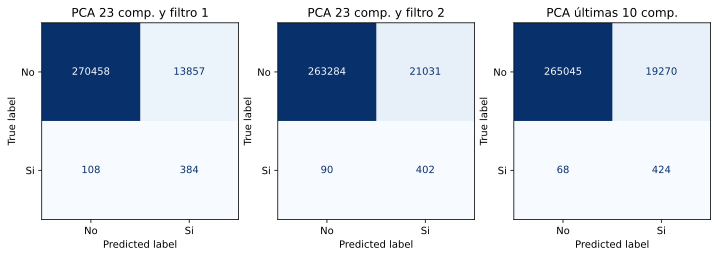

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.style.use("default")

labels = ["No", "Si"]

fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

ConfusionMatrixDisplay.from_predictions(
    y, 
    filtro23_1,
    colorbar       = False,
    cmap           = "Blues",
    values_format  = "0.0f",
    display_labels = labels,
    ax             = ax[0]
)
ConfusionMatrixDisplay.from_predictions(
    y, 
    filtro23_2,
    colorbar       = False,
    cmap           = "Blues",
    values_format  = "0.0f",
    display_labels = labels,
    ax             = ax[1]
)
ConfusionMatrixDisplay.from_predictions(
    y, 
    filtro10, 
    colorbar       = False,
    cmap           = "Blues",
    values_format  = "0.0f",
    display_labels = labels,
    ax             = ax[2]
)
ax[0].set_title("PCA 23 comp. y filtro 1")
ax[1].set_title("PCA 23 comp. y filtro 2")
ax[2].set_title("PCA últimas 10 comp.")

## Isolation Forest y Extended Isolation Forest

Continuemos usando la base de datos anterior, pero con estos nuevos algoritmos: **Isolation Forest** (IF), **Extended Isolation Forest** (EIF), y **Random Forest** (RF). Este último, solo lo podemos usar pues tenemos la variable respuesta, pero además servirá de punto comparativo para nuestros resultados.

Notemos, como es de esperar, que una mínima cantidad de observaciones son efectivamente fraude, y el objetivo es detectar la mayor cantidad de fraudes posibles, pues lo que una entidad bancaria hace, es bloquear dichas tarjetas antes de que les sigan robando más, y luego el cliente del banco puede solicitar el desbloqueo.

Como utilizaremos un Random Forest para comparar (suponiendo que tuviesemos la clase), realizaremos el procedimiento train test split, que no se haría cuando solo hicieramos los algoritmos IF o EIF. Pero esto nos ayudará a comparar la cantidad de fraudes que puede detectar cada algoritmo

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size    = 0.4,
    random_state = 2022,
    stratify     = y
)

print("Frecuencias relativas de variable respuesta:")
print(y.value_counts(normalize=True))
print("Frecuencias de variable respuesta en testeo:")
print(y_test.value_counts())

Frecuencias relativas de variable respuesta:
0    0.998273
1    0.001727
Name: Class, dtype: float64
Frecuencias de variable respuesta en testeo:
0    113726
1       197
Name: Class, dtype: int64


### Isolation Forest

En primera instancia entrenemos el modelo **Isolation Forest**, a este le podemos ajustar los siguientes hiperparámetros.

- `n_estimators` : El número de estimadores base para cada ensamble, recordemos que estará ensamblando Isolation Trees.
- `contamination`: Es el porcentaje esperado de anomalias en el set.
- `max_features` : Número de features para cada estimador base.

Una vez entrenado, podremos usar el método `decision_function` que entrega un puntaje entre -1 y 1, donde valores bajos hacen referencia a que el dato es anómalo.

In [22]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest(
    n_estimators  = 50,
    contamination = 0.001727,
    random_state  = 2022,
    n_jobs        = -1
)
IF.fit(X_train.values)
dec_func = IF.decision_function(X_test.values)

In [23]:
iqr = np.diff(np.quantile(dec_func, [1/4, 3/4]))
filtro_IF = dec_func < np.quantile(dec_func, 1/4) - 1.5 * iqr

if_cm = confusion_matrix(y_test, filtro_IF)

print("Matriz de confusión Isolation Forest:")
print(if_cm)

Matriz de confusión Isolation Forest:
[[109230   4496]
 [    37    160]]


Detectamos 160 de 196 anomalías posibles.

### Extended Isolation forest
Este algoritmo es una optimización del anterior y es relativamente nuevo. Es una versión que fue publicada a fines del 2018, y su paper fue revisado a mediados del año 2020.

¡Esto evidencia que un científico de datos, debe siempre estar al día con los nuevos algoritmos que van aparenciendo!

Extended isolation forest tiene menos hiperparámetros que utilizar, pues usa los por default de un IF. El hiperparámetro nuevo que aparece es ExtensionLevel. A medida que ExtensionLevel aumenta, el sesgo del algoritmo es reducido. La idea de tener múltiples niveles de extensión, puede ser útil en casos donde el rango dinámico de la data en varias dimensiones es muy diferente. En nuestro caso la data tiene valores similares entre sus columnas, por lo que utilizaremos un nivel de extensión de 1. Un valor de 0 es igual a utilizar el IF estándar.

Para mayor detalle, leer el paper de los creadores: <https://arxiv.org/pdf/1811.02141.pdf>.

Nota: las matrices deben estar en formato `array` de `numpy` para funcionar en este algoritmo.


In [24]:
# !pip install eif==1.0.2
# OJO: este algoritmo tarda bastante.
import eif

EIF = eif.iForest(
    X              = X_train.values,
    ntrees         = 50,
    sample_size    = 256,
    ExtensionLevel = 1
)

predicciones_EIF = EIF.compute_paths(X_test.values)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
filtro_EIF = predicciones_EIF > 0.5
eif_cm = confusion_matrix(y_test, filtro_EIF)

print("Matriz de confusión Extended Isolation Forest:")
print(eif_cm)

Matriz de confusión Extended Isolation Forest:
[[109510   4216]
 [    33    164]]


### Random Forest

Este algoritmo de clasificación lo hemos visto a detalle en clases anteriores, y lo utilizaremos solo a nivel comparativo.

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=2022, class_weight="balanced")
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=2022)

In [27]:
filtro_RF = rf.predict(X_test) == 1
rf_cm = confusion_matrix(y_test, filtro_RF)
rf_cm


array([[113721,      5],
       [    55,    142]])

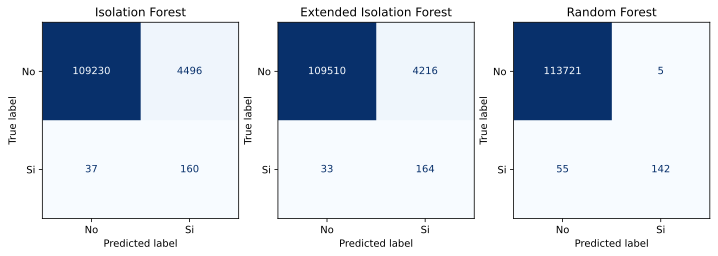

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

ConfusionMatrixDisplay.from_predictions(
    y_test, 
    filtro_IF,
    colorbar       = False,
    cmap           = "Blues",
    values_format  = "0.0f",
    display_labels = labels,
    ax             = ax[0]
)
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    filtro_EIF,
    colorbar       = False,
    cmap           = "Blues",
    values_format  = "0.0f",
    display_labels = labels,
    ax             = ax[1]
)
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    filtro_RF, 
    colorbar       = False,
    cmap           = "Blues",
    values_format  = "0.0f",
    display_labels = labels,
    ax             = ax[2]
)
ax[0].set_title("Isolation Forest")
ax[1].set_title("Extended Isolation Forest")
ax[2].set_title("Random Forest");

Observaciones:
- Random Forest comete muchos menos errores que Isolation Forest o Extended Isolation Forest. Sin embargo, la cantidad de fraudes detectados es mayor para los algoritmos de detección de anomalías.

- Extended isolation forest es capaz de obtener más anomalías que el convencional, ajustando un correcto punto de corte. Pero en la práctica es difícil saber el punto correcto, pues no hay etiqueta para ir comparando. 

La pregunta ¿Qué es mejor?, como suele ser: Depende.

Un banco, por ejemplo, tiene la siguiente dicotomía: Entre más tarjetas preventivas bloquea, menos tiene que pagar por fraudes. Sin embargo, ciertos clientes pueden molestarse por dicho bloqueo e irse del banco. Dicha decisión es tomada por el área gerencial. Nosotros como científicos de datos, debemos entregar ambas opciones: maximizar la cantidad de fraudes, o minimizar el error.

Por otro lado, no es posible crear el algoritmo de Random Forest sin la etiqueta clasificadora, por lo que simplemente no es una opción si no se cuenta con dicho dato.

## Ejercicios

Utilizaremos la base de datos cardio.mat, esta base de datos ya viene con la clase de interés etiquetada (patología/no patología, simil a anomalía/no anomalía). Para leer más información de la base de datos puede visitar este link:

http://odds.cs.stonybrook.edu/cardiotocogrpahy-dataset/



In [29]:
import urllib.request
from scipy.io import loadmat
# Descarga de datos
url = "https://raw.githubusercontent.com/DiegoHoliwis/Diplomado_DS/main/Bases_Python/cardio.mat"
ruta, _ = urllib.request.urlretrieve(url, "./cardio.mat")
# Importación a python
cardio = loadmat(ruta)
X = cardio["X"]
y = cardio["y"].flatten().astype(int)

**a)** Cargue los datos adjuntos en el bloque de código anterior, la variable `X` contendrá los predictores e `y` indicará si la observación corresponde a dato anómalo o no (1 y 0 respectivamente), ambos en formato `array` de `numpy`. Indique el porcentaje de datos anómalos reales.

In [30]:
# Responda aquí

**b)** Haga los modelos Isolation Forest y Extended Isolation Forest, eligiendo un valor de contaminación apropiado en el caso de Isolation Forest (puede basarse en los porcentajes obtenidos en la pregunta anterior) y con 100 árboles en cada modelo.

In [31]:
# Responda aquí

**c)** Visualice en un gráfico la distribución de scores de anomalías de los dos modelos. Señale diferencias si es que existen.

In [32]:
# Responda aquí

**d)** ¿Cuántas observaciones fueron clasificadas como anomalías por cada modelo? (Utilice de criterio un score mayor a 0.5). ¿Cuántos pacientes presentaban patología? Muestre una tabla de confusión y comente la capacidad de ajuste de los modelos de anomalías.

In [33]:
# Responda aquí